# Checkers with Q-Learning and Generative Models
by Dilochan Karki, Fall 2023

## Introduction

Reinforcement Learning (RL) encapsulates the essence of autonomous decision-making by trying to solve a problem without any labelled data to supervise the training process. Unlike supervised and unsupervised learning, RL empowers machines to autonomously derive insights and calculate success rates through continuous learning. The fundamental components of RL can be broken down as: 
1. Agent: entrusted with decision-making responsibilities
2. Actions: the events initiated by the Agent
3. Environment: the contextual stage where actions unfold, adhering to predefined rules and eliciting responses
4. Rewards: a crucial feedback mechanism. Rewards serve as the compass guiding the Agent, offering valuable insights into the success of its decisions. 

With a combination of the Agent, Actions, Environment, and Rewards, RL helps achieve decision-making systems that evolve through iterative learning. Recently it has emerged as a game-changing approach for tackling complex games, offering a dynamic and adaptive methodology that enables artificial intelligence to learn optimal strategies through iterative interaction. In the realm of game-solving, RL has showcased remarkable achievements, challenging traditional gaming paradigms and demonstrating its capacity to master games of unprecedented complexity. For this project, I will be developing an agent through reinforcement learning that is capable of playing "Checkers" and demonstrate its rates of winnning a game through iterative training.

### Checkers

Checkers is a popular board game along with various variants such as the popular Chinese checkers. For this project, I would like to implement the standard 8x8 American checkers with 12 pawns at each side. Each player commands twelve distinct game pieces, traditionally distinguished by color—commonly red and black. The pieces are divided into men and kings. Men are single pieces whereas kings are two pieces of same colour stacked on top of each other. There are two different way to move the pieces. In a simple move, the piece is moved one square diagonally to adjacent unoccupied cell. Regular pieces, often called "men" move diagonally forward only. The game introduces a compelling twist with the notion of "kinging." When a man successfully navigates to the opponent's back rank, it is promoted to a "king". Kings possess enhanced mobility, moving diagonally both forward and backward. Capturing with kings follows the same principle of leaping over an opponent's piece, but now it can be done in any direction. The objective of a player is to capture or block all of the opponent's pieces, rendering them incapable of making a legal move. Players can achieve this by diagonally advancing their pieces across the board, moving exclusively to dark squares. The pieces jump when there is an opponent's piece in the diagonally adjacent cell. It jumps over it to an adjacent empty cell and thus, removing the opponent's piece from the game. A player wins if all the pieces of opponent have been captured and removed from the game or no legal move remains. Turns alternate between players, with strategic positioning and anticipating the adversary's moves becoming critical. Stalemates are declared when neither player can make a legal move, resulting in a draw.

<img src="top-view-flat-checkers-chessboard-vector-21376702.jpg" alt="Checkers Board" style="width:300px;"/>


The game can be modeled by a 8x8 matrix with a value representing each player as content of a cell. However, since the pieces move only diagonally along the black cells of a checkers board, the board can be modeled with a compressed version with a 32x1 array by removing those unreachable cells. For this project, I will be using the functions that model the pieces and board, and define the rules for them from [Btsan-checkersbot]. In the case of reinforcement learning, the player will be the agent, positios of the king and men pieces would be the states and actions would be the moves made on the pieces and capturing opponent pieces. The outcomes of these actions at each state would be defined as rewards which would be positive if the player is closer to winning, else negative. The state-action function, also defined as Q-function, to predict the expected sum of rewards could be modeled as a table, but considering the large number of possible game states and actions, this would be infeasible. Thus, a neural network can be used for the approximation of the Q-function. It will take the board positions and actions taken along with a metric to measure the chances of winning for a given state-action value.  



### Reinforcement Learning with Neural Networks

At every iteration during training, the agent has to calculate the predicted value from the given state-action approximation provided by a neural network. The training dataset which is the set of possible states and actions is built throughout training. The agent is trained through multiple generations, and in each of these generations a number of games are played. The Q-value, a value assigned to quantify each set of state-action, is updated at each generation to maximize the reward(chances of winning). For this, a best policy or strategy is defined to determine the best action at every state. This can be done through the Bellman Equation which estimates the value of each state or board position by calculating the future return the state can generate.  

$$
V(s) = R(s) + \gamma \cdot \max_a [Q(s, a)]
$$

where:

- V(s) is the value of state s,
- R(s) is the immediate reward obtained in state s,
- γ is the discount factor (a value between 0 and 1),
- maximium(a) of [Q(s, a)] represents the maximum expected cumulative reward achievable by taking the best action a in state s
- Q(s, a) is the action-value function, representing the expected cumulative reward for taking action a in state s.

The discount factor helps determine the significance of future rewards. It represents the extent to which future rewards should be considered when estimating the value of a state or state-action pair. Its value lies between 0 and 1, higher values signifying the future rewards are more significant and will result in a long term payoff. Hence, with the Bellman equation, the optimal Q-value for a new state to calculate targe values as mentioned in [Q-learning] can be determined as:

$$
Q_{new}(s_t,a_t) = Q_{old}(s_t,a_t) + \alpha [ [ R(s_t) + \gamma \cdot \max_a [Q(s_{t+1}, a)] ] - Q_{old}(s_t,a_t)]
$$

where:

- α is the learning rate which signifies the step-size taken over old value based on newly calculated Q-values. 

### Quantifying the board position

A metrics is function used to evaluate a certain board position defined as the `get_metrics` function below. This function calculates a value for reward using criterias such as number of enemies captured, number of potential moves, number of men, number of kings, number of pieces in enemy rows, number of pieces in own rows, number of immune and supported pieces and number of stranded enemies. A certain weight is assigned to each of these variables, an approach similar to [Henning, RL-Checkers], to calculate a score. The score is used to create a label 0(for negative score) and 1(for positive score) and the individual metrics used as training data for the neural network to fit. 

## Methods

### Adversarial Neural Networks for Checkers Agent

Generative models are a type of statistical models that create new examples of data [Goodfellow-Generative]. In unsupervised learning, these models help with tasks like figuring out how likely something is to happen, describing data points, and sorting things into groups based on these probabilities. Its goal is to study training samples and learn the probability distribution that generated them. Then, using this model, more examples are generated which are then used to train the agent. With this adversarial process, I will be training two models, a generative model called `gen_model` and a discriminative model called `board_model`. The generative model will capture the data distribution and the discriminate model will estimate the probability that the board position metric came from the training data and not the generative model. The model will be trained for multiples generation with the goal of maximizing the chances that the discriminative model will make a mistake.

Below are the util functions that are used to move the board pieces, define rules, generate board positions and determine board positions available from [Btsan-checkersbot]. Along with that, it also contains the functions to generate metrics, generate next possible board positions for a given board position and determine winner for a given board position. 

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.models import model_from_json
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import matplotlib.pyplot as plt



In [2]:
# number of opponent pieces captured (max = 12)
def num_captured(board):
	return 12 - np.sum(board < 0)

def num_branches(board, x, y):
	count = 0
	if (board[x, y] >= 1 and x < 6):
		if (y < 6):
			if (board[x+1, y+1] < 0 and board[x+2, y+2] == 0):
				board[x+2, y+2] = board[x, y]
				board[x, y] = 0
				temp = board[x+1, y+1]
				board[x+1, y+1] = 0
				count += num_branches(board, x+2, y+2) + 1
				board[x+1, y+1] = temp
				board[x, y] = board[x+2, y+2]
				board[x+2, y+2] = 0
		if (y > 1):
			if (board[x+1, y-1] < 0 and board[x+2, y-2] == 0):
				board[x+2, y-2] = board[x, y]
				board[x, y] = 0
				temp = board[x+1, y-1]
				board[x+1, y-1] = 0
				count += num_branches(board, x+2, y-2) + 1
				board[x+1, y-1] = temp
				board[x, y] = board[x+2, y-2]
				board[x+2, y-2] = 0
	if (board[x, y] == 3 and x > 0):
		if (y < 6):
			if (board[x-1, y+1] < 0 and board[x-2, y+2] == 0):
				board[x-2, y+2] = board[x, y]
				board[x, y] = 0
				temp = board[x-1, y+1]
				board[x-1, y+1] = 0
				count += num_branches(board, x-2, y+2) + 1
				board[x-1, y+1] = temp
				board[x, y] = board[x-2, y+2]
				board[x-2, y+2] = 0
		if (y > 1):
			if (board[x-1, y-1] < 0 and board[x-2, y-2] == 0):
				board[x-2, y-2] = board[x, y]
				board[x, y] = 0
				temp = board[x-1, y-1]
				board[x-1, y-1] = 0
				count += num_branches(board, x-2, y-2) + 1
				board[x-1, y-1] = temp
				board[x, y] = board[x-2, y-2]
				board[x-2, y-2] = 0
	return count

def possible_moves(board):
	count = 0
	for i in range(0, 8):
		for j in range(0, 8):
			if (board[i, j] > 0):
				count += num_branches(board, i, j)
	if (count > 0):
		return count
	for i in range(0, 8):
		for j in range(0, 8):
			if (board[i, j] >= 1 and i < 7):
				if (j < 7):
					count += (board[i+1, j+1] == 0)
				if (j > 0):
					count += (board[i+1, j-1] == 0)
			if (board[i, j] == 3 and i > 0):
				if (j < 7):
					count += (board[i-1, j+1] == 0)
				elif (j > 0):
					count += (board[i-1, j-1] == 0)
	return count


def game_winner(board):
	if (np.sum(board < 0) == 0):
		return 1
	elif (np.sum(board > 0) == 0):
		return -1
	if (possible_moves(board) == 0):
		return -1
	elif (possible_moves(reverse(board)) == 0):
		return 1
	else:
		return 0

def at_enemy(board):
	count = 0
	for i in range(5, 8):
		count += np.sum(board[i] == 1) + np.sum(board[i] == 3)
	return count

def at_middle(board):
	count = 0
	for i in range(3, 5):
		count += np.sum(board[i] == 1) + np.sum(board[i] == 3)
	return count

def num_men(board):
	return np.sum(board == 1)

def num_kings(board):
	return np.sum(board == 3)

def capturables(board): # possible number of unsupported enemies
	count = 0
	for i in range(1, 7):
		for j in range(1, 7):
			if (board[i, j] < 0):
				count += (board[i+1, j+1] >= 0 and board[i+1, j-1] >= 0 and  board[i-1, j+1] >= 0 and board[i-1, j-1] >= 0)
	return count

def semicapturables(board): # number of own units with at least one support
	return (12 - uncapturables(board) - capturables(reverse(board)))

def uncapturables(board): # number of own units that can't be captured
	count = 0
	for i in range(1, 7):
		for j in range(1, 7):
			if (board[i, j] > 0):
				count += ((board[i+1, j+1] > 0 < board[i+1, j-1]) or (board[i-1, j+1] > 0 < board[i-1, j-1]) or (board[i+1, j+1] > 0 < board[i-1, j+1]) or (board[i+1, j-1] > 0 < board[i-1, j-1]))
	count += np.sum(board[0] == 1) + np.sum(board[0] == 3) + np.sum(board[1:7, 0] == 1) + np.sum(board[1:7, 0] == 3) + np.sum(board[7] == 1) + np.sum(board[7] == 3) + np.sum(board[1:7, 7] == 1) + np.sum(board[1:7, 7] == 3)
	return count

def reverse(board):
	b = -board
	b = np.fliplr(b)
	b = np.flipud(b)
	return b

def get_metrics(board): # returns [label, 10 labeling metrics]
	b = expand(board)

	capped = num_captured(b)
	potential = possible_moves(b) - possible_moves(reverse(b))
	men = num_men(b) - num_men(-b)
	kings = num_kings(b) - num_kings(-b)
	caps = capturables(b) - capturables(reverse(b))
	semicaps = semicapturables(b)
	uncaps = uncapturables(b) - uncapturables(reverse(b))
	mid = at_middle(b) - at_middle(-b)
	far = at_enemy(b) - at_enemy(reverse(b))
	won = game_winner(b)

	score = 4*capped + potential + men + 3*kings + caps + 2*semicaps + 3*uncaps + 2*mid + 3*far + 100*won
	if (score < 0):
		return np.array([-1, capped, potential, men, kings, caps, semicaps, uncaps, mid, far, won])
	else:
		return np.array([1, capped, potential, men, kings, caps, semicaps, uncaps, mid, far, won])

def np_board():
	return np.array(get_board())

def get_board():
	return [1, 1, 1, 1,  1, 1, 1, 1,  1, 1, 1, 1,  0, 0, 0, 0,  0, 0, 0, 0,  -1, -1, -1, -1,  -1, -1, -1, -1,  -1, -1, -1, -1]

def expand(board):
	b = np.zeros((8, 8), dtype='b')
	for i in range(0, 8):
		if (i%2 == 0):
			b[i] = np.array([0, board[i*4], 0, board[i*4 + 1], 0, board[i*4 + 2], 0, board[i*4 + 3]])
		else:
			b[i] = np.array([board[i*4], 0, board[i*4 + 1], 0, board[i*4 + 2], 0, board[i*4 + 3], 0])
	return b

def compress(board):
	b = np.zeros((1,32), dtype='b')
	for i in range(0, 8):
		if (i%2 == 0):
			b[0, i*4 : i*4+4] = np.array([board[i, 1], board[i, 3], board[i, 5], board[i, 7]])
		else:
			b[0, i*4 : i*4+4] = np.array([board[i, 0], board[i, 2], board[i, 4], board[i, 6]])
	return b

def generate_branches(board, x, y):
	bb = compress(board)
	if (board[x, y] >= 1 and x < 6):
		temp_1 = board[x, y]
		if (y < 6):
			if (board[x+1, y+1] < 0 and board[x+2, y+2] == 0):
				board[x+2, y+2] = board[x, y]
				if (x+2 == 7):
					board[x+2, y+2] = 3
				temp = board[x+1, y+1]
				board[x+1, y+1] = 0
				if (board[x, y] != board[x+2, y+2]):
					board[x, y] = 0
					bb = np.vstack((bb, compress(board)))
				else:
					board[x, y] = 0
					bb = np.vstack((bb, generate_branches(board, x+2, y+2)))
				board[x+1, y+1] = temp
				board[x, y] = temp_1
				board[x+2, y+2] = 0
		if (y > 1):
			if (board[x+1, y-1] < 0 and board[x+2, y-2] == 0):
				board[x+2, y-2] = board[x, y]
				if (x+2 == 7):
					board[x+2, y-2] = 3
				temp = board[x+1, y-1]
				board[x+1, y-1] = 0
				if (board[x, y] != board[x+2, y-2]):
					board[x, y] = 0
					bb = np.vstack((bb, compress(board)))
				else:
					board[x, y] = 0
				bb = np.vstack((bb, generate_branches(board, x+2, y-2)))
				board[x+1, y-1] = temp
				board[x, y] = temp_1
				board[x+2, y-2] = 0
	if (board[x, y] == 3 and x > 0):
		if (y < 6):
			if (board[x-1, y+1] < 0 and board[x-2, y+2] == 0):
				board[x-2, y+2] = board[x, y]
				board[x, y] = 0
				temp = board[x-1, y+1]
				board[x-1, y+1] = 0
				bb = np.vstack((bb, generate_branches(board, x-2, y+2)))
				board[x-1, y+1] = temp
				board[x, y] = board[x-2, y+2]
				board[x-2, y+2] = 0
		if (y > 1):
			if (board[x-1, y-1] < 0 and board[x-2, y-2] == 0):
				board[x-2, y-2] = board[x, y]
				board[x, y] = 0
				temp = board[x-1, y-1]
				board[x-1, y-1] = 0
				bb = np.vstack((bb, generate_branches(board, x-2, y-2)))
				board[x-1, y-1] = temp
				board[x, y] = board[x-2, y-2]
				board[x-2, y-2] = 0
	return bb

def generate_next(board):
	bb = np.array([get_board()])
	for i in range(0, 8):
		for j in range(0, 8):
			if (board[i, j] > 0):
				bb = np.vstack((bb, generate_branches(board, i, j)[1:]))
	if (len(bb) > 1):
		return bb[1:]
	for i in range(0, 8):
		for j in range(0, 8):
			if (board[i, j] >= 1 and i < 7):
				temp = board[i, j]
				if (j < 7):
					if (board[i+1, j+1] == 0):
						board[i+1, j+1] = board[i, j]
						if (i+1 == 7):
							board[i+1, j+1] = 3
						board[i, j] = 0
						bb = np.vstack((bb, compress(board)))
						board[i, j] = temp
						board[i+1, j+1] = 0
				if (j > 0):
					if (board[i+1, j-1] == 0):
						board[i+1, j-1] = board[i, j]
						if (i+1 == 7):
							board[i+1, j-1] = 3
						board[i, j] = 0
						bb = np.vstack((bb, compress(board)))
						board[i, j] = temp
						board[i+1, j-1] = 0
			if (board[i, j] == 3 and i > 0):
				if (j < 7):
					if (board[i-1, j+1] == 0):
						board[i-1, j+1] = board[i, j]
						board[i, j] = 0
						bb = np.vstack((bb, compress(board)))
						board[i, j] = board[i-1, j+1]
						board[i-1, j+1] = 0
				elif (j > 0):
					if (board[i-1, j-1] == 0):
						board[i-1, j-1] = board[i, j]
						board[i, j] = 0
						bb = np.vstack((bb, compress(board)))
						board[i, j] = board[i-1, j-1]
						board[i-1, j-1] = 0
	return bb[1:]

def random_board():
	b = get_board()
	promote = 0.9
	remove = 0.4
	add = 0
	for piece in b:
		# randomly promote, remove, or add piece
		rand = np.random.random()
		if piece != 0 and rand > promote:
			piece = piece * 3
			promote = promote + 0.005
		elif piece != 0 and rand < remove:
			piece = 0
			remove = remove - 0.025
			add = add + 0.05
		elif piece == 0 and rand < add:
			if np.random.random() > 0.5:
				piece = 1
			else:
				piece = -1
	return b


For the generative model, I have defined a neural network architecture consisting of three dense layers with 32, 16, and 1 units respectively, each using the Rectified Linear Unit (ReLU) activation function. I will also be using the Nadam optimizer to converge the model with binary cross-entropy loss. In the subsequent data preparation steps, an initial game board state is expanded and used to generate a new board state. The input for the model is a vector of length 32 representing the compressed form of the game state, where elements with value zero represent empty fields, 1 represent the agent’s normal pieces and 2 represent the agent’s kings. Pieces of the opponent are represented with the corresponding negative values. After defining the model, a series of possible board positions is defined for a given number of games. For each of these position, heuristics are determined through the metrics calculated using `get_metrics` function. Finally, the generative model is trained to predict the games outcome based on these metrics and labels. 

In [4]:
gen_model = Sequential()
gen_model.add(Dense(32, input_dim=10))
gen_model.add(Dense(4, activation='relu',  kernel_regularizer=regularizers.l2(0.01)))
gen_model.add(Dense(1, activation='sigmoid',  kernel_regularizer=regularizers.l2(0.01)))
gen_model.compile(optimizer='adam', loss='binary_crossentropy')

# generate 5 sets of 1000 game states, used to train generative model
# generating 5 sets of training data
for i in range(0, 5):
  # create a random board and expand it from 32 1D array to a 2D array
  board_0 = expand(random_board())
  # next possible board states
  boards_1 = generate_next(board_0)
  boards_2 = np.zeros((0,32))
  counter_1 = counter_2 = 0
  while (len(boards_1) + len(boards_2) < 1000):
    temp = counter_1
    for counter_1 in range(temp, min(temp + 10, len(boards_1))):
      if (possible_moves(reverse(expand(boards_1[counter_1]))) > 0):
        boards_2 = np.vstack((boards_2, generate_next(reverse(expand(boards_1[counter_1])))))
    temp = counter_2
    for counter_2 in range(temp, min(temp + 10, len(boards_2))):
      if (possible_moves(expand(boards_2[counter_2])) > 0):
        boards_1 = np.vstack((boards_1, generate_next(expand(boards_2[counter_2]))))

  # concat 1000 game states

  data = np.vstack((boards_1, boards_2))
  boards_2 = np.zeros((0, 32))
  counter_2 = 0
  boards_1 = np.vstack((boards_1[-10:], generate_next(board_0)))
  counter_1 = len(boards_1) - 1
  metrics = np.zeros((0, 11))

  # calculate/save heuristic metrics for each game state
  for board in iter(data):
    metrics = np.vstack((metrics, get_metrics(board)))

  # pass to generative model
  history = gen_model.fit(metrics[:, 1:], metrics[:, 0], epochs=32, batch_size=64, verbose=0)

Following this, I have created another model `board_model` that acts as the discriminative model which will be predicting the probability of winning from a given board. It determines a positive evaluation for a winning game and a negative evaluation for a losing game. The model is looped through all of the generated board positions. A set of metrics are determined for each of these board positions and using these metrics the probability of winning from this board is determined. Then, confidence values are determined for the metrics evaluation and the probabilistic distribution. This will act as weights for the discriminative model to focus on the evaluations with higher probabilities. This model will determine the initial Q-value, which is then used to train the agent iteratively to produce better evaluations.

In [5]:
# Board model
board_model = Sequential()

# input dimensions is 32 board position values
board_model.add(Dense(64 , activation='relu', input_dim=32))

# use regularizers, to prevent fitting noisy labels
board_model.add(Dense(32 , activation='relu', kernel_regularizer=regularizers.l2(0.01)))
board_model.add(Dense(16 , activation='relu', kernel_regularizer=regularizers.l2(0.01))) # 16
board_model.add(Dense(8 , activation='relu', kernel_regularizer=regularizers.l2(0.01))) # 8

# output isn't squashed, because it might lose information
board_model.add(Dense(1 , activation='linear', kernel_regularizer=regularizers.l2(0.01)))
board_model.compile(optimizer='nadam', loss='binary_crossentropy')


probabilistic = gen_model.predict_on_batch(metrics[:, 1:])

# calculate confidence score for each probabilistic label using error between probabilistic and weak label
confidence = 1/(1 + np.absolute(metrics[:, 0] - probabilistic[:, 0]))

# fit labels to {-1, 1}
probabilistic = np.sign(probabilistic)
board_model.fit(data, probabilistic, epochs=32, batch_size=64, sample_weight=confidence, verbose=0)

board_json = board_model.to_json()
with open('board_model.json', 'w') as json_file:
	json_file.write(board_json)
board_model.save_weights('board_model.h5')


Initially, to explore the models performance, I have trained the model for smaller generations and played fewer games, to see how much winning rate it can provide. The model is refitted during each generation and for each generation the agent will play a certain number of games. Using the Bellman Equation, Q-values are updated for each generation. A negative reward is assigned for games leading to a loss, and positive reward is assigned for games leading to a win or draw. 

In [18]:
def run_generations(no_generations, no_games, learning_rate, discount_factor, epochs=16, batch_size=256):

    json_file = open('board_model.json', 'r')
    board_json = json_file.read()
    json_file.close()

    reinforced_model = model_from_json(board_json)
    reinforced_model.load_weights('board_model.h5')
    reinforced_model.compile(optimizer='adadelta', loss='mean_squared_error')

    data = np.zeros((1, 32))
    labels = np.zeros(1)
    win = lose = draw = 0
    winrates = []

    for gen in range(0, no_generations):
        for game in range(0, no_games):
            temp_data = np.zeros((1, 32))
            board = expand(np_board())
            player = np.sign(np.random.random() - 0.5)
            turn = 0
            while (True):
                moved = False
                boards = np.zeros((0, 32))
                if (player == 1):
                    boards = generate_next(board)
                else:
                    boards = generate_next(reverse(board))

                scores = reinforced_model.predict_on_batch(boards)
                max_index = np.argmax(scores)
                best = boards[max_index]

                if (player == 1):
                    board = expand(best)
                    temp_data = np.vstack((temp_data, compress(board)))
                else:
                    board = reverse(expand(best))

                player = -player

                # punish losing games, reward winners  & drawish games reaching more than 200 turns
                winner = game_winner(board)
                if (winner == 1 or (winner == 0 and turn >= 200) ):
                    if winner == 1:
                        win = win + 1
                    else:
                        draw = draw + 1
                    reward = 10
                    old_prediction = reinforced_model.predict_on_batch(temp_data[1:])
                    optimal_future_value = np.ones(old_prediction.shape)
                    temp_labels = old_prediction + learning_rate * (reward + discount_factor * optimal_future_value - old_prediction )
                    data = np.vstack((data, temp_data[1:]))
                    labels = np.vstack((labels, temp_labels))
                    break
                elif (winner == -1):
                    lose = lose + 1
                    reward = -10
                    old_prediction = reinforced_model.predict_on_batch(temp_data[1:])
                    optimal_future_value = -1*np.ones(old_prediction.shape)
                    temp_labels = old_prediction + learning_rate * (reward + discount_factor * optimal_future_value - old_prediction )
                    data = np.vstack((data, temp_data[1:]))
                    labels = np.vstack((labels, temp_labels))
                    break
                turn = turn + 1

            if ((game+1) % no_games == 0):
                reinforced_model.fit(data[1:], labels[1:], epochs=epochs, batch_size=batch_size, verbose=0)
                data = np.zeros((1, 32))
                labels = np.zeros(1)
        winrate = int((win+draw)/(win+draw+lose)*100)
        winrates.append(winrate)
        
        if gen%100 == 0:
            print(f"Completed {gen%100}th iteration.")

    reinforced_model.save_weights(f'reinforced_model_gens{no_generations}_games{no_games}.h5')
    reinforced_json = reinforced_model.to_json()
    with open(f'reinforced_model_gens{no_generations}_games{no_games}.json', 'w') as json_file:
        json_file.write(reinforced_json)

    print('Checkers Board Model updated by reinforcement learning & saved to: reinforced_model.json/h5')
    return winrates

## Results

Checkers Board Model updated by reinforcement learning & saved to: reinforced_model.json/h5
Final win/draw rate : 72%


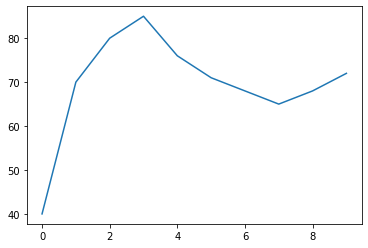

In [12]:
no_generations = 10
no_games = 10
learning_rate = 0.5
discount_factor = 0.95
winrates = run_generations(no_generations, no_games, learning_rate, discount_factor)
generations = range(0, no_generations)
print("Final win/draw rate : " + str(winrates[no_generations-1])+"%" )
plt.plot(generations,winrates)
plt.show()

After plotting the winrates for each generation as above, it can be seen that the agent initially has a winning rate of only 40%, which means the agent is performing terribly and losing most of the games. However, as the agent goes through consecutive generations, the winrate increase steadily. The final winrate can be observed to be 72% and the peak winrate is higher than 80%.

Checkers Board Model updated by reinforcement learning & saved to: reinforced_model.json/h5
Final win/draw rate : 68%


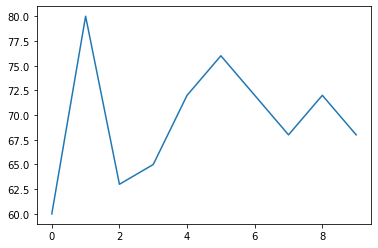

In [13]:
no_generations = 10
no_games = 10
learning_rate = 0.1
discount_factor = 0.95
winrates = run_generations(no_generations, no_games, learning_rate, discount_factor)
generations = range(0, no_generations)
print("Final win/draw rate : " + str(winrates[no_generations-1])+"%" )
plt.plot(generations,winrates)
plt.show()

For a lower learning rate, i.e. changed from 0.5 to 0.1, it can be observed that the winrate fluctuates often, and the final winrate obtained is significantly lower as well. The peak winrate is lower as well i.e. only 80%. A fluctuating performance is not promising as for agent, steady performance of high winrates is required. So, futher experiments with different hyperparameters is done.

Checkers Board Model updated by reinforcement learning & saved to: reinforced_model.json/h5
Final win/draw rate : 62%


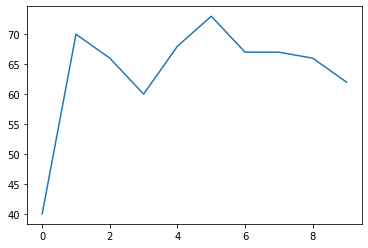

In [11]:
no_generations = 10
no_games = 10
learning_rate = 0.05
discount_factor = 0.95
winrates = run_generations(no_generations, no_games, learning_rate, discount_factor)
generations = range(0, no_generations)
print("Final win/draw rate : " + str(winrates[no_generations-1])+"%" )
plt.plot(generations,winrates)
plt.show()

As expected, even lower learning rate resulted in significantly lower winrates compared to previous results.
However, the number of iterations and games played is not enough. Thus, the generations and number of games played each generation is further increased and its results are observed.

Checkers Board Model updated by reinforcement learning & saved to: reinforced_model.json/h5
Final win/draw rate : 72%


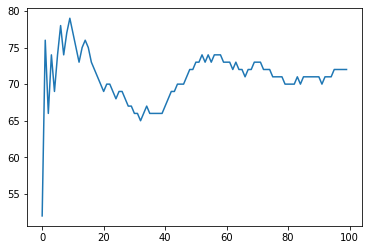

In [14]:
no_generations = 100
no_games = 100
learning_rate = 0.1
discount_factor = 0.95
winrates = run_generations(no_generations, no_games, learning_rate, discount_factor)
generations = range(0, no_generations)
print("Final win/draw rate : " + str(winrates[no_generations-1])+"%" )
plt.plot(generations,winrates)
plt.show()

Checkers Board Model updated by reinforcement learning & saved to: reinforced_model.json/h5
Final win/draw rate : 78%


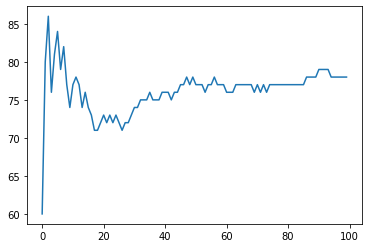

In [16]:
no_generations = 100
no_games = 100
learning_rate = 0.5
discount_factor = 0.95
winrates = run_generations(no_generations, no_games, learning_rate, discount_factor)
generations = range(0, no_generations)
print("Final win/draw rate : " + str(winrates[no_generations-1])+"%" )
plt.plot(generations,winrates)
plt.show()

Checkers Board Model updated by reinforcement learning & saved to: reinforced_model.json/h5
Final win/draw rate : 73%


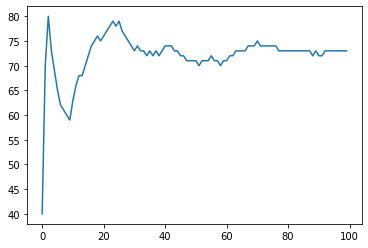

In [17]:
no_generations = 100
no_games = 100
learning_rate = 0.01
discount_factor = 0.95
winrates = run_generations(no_generations, no_games, learning_rate, discount_factor)
generations = range(0, no_generations)
print("Final win/draw rate : " + str(winrates[no_generations-1])+"%" )
plt.plot(generations,winrates)
plt.show()

Checkers Board Model updated by reinforcement learning & saved to: reinforced_model.json/h5
Final win/draw rate : 75%


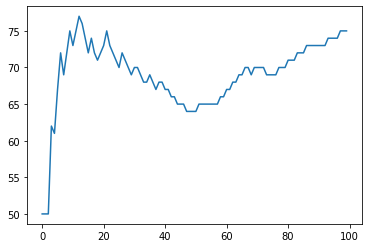

In [18]:
no_generations = 100
no_games = 100
learning_rate = 0.05
discount_factor = 0.95
winrates = run_generations(no_generations, no_games, learning_rate, discount_factor)
generations = range(0, no_generations)
print("Final win/draw rate : " + str(winrates[no_generations-1])+"%" )
plt.plot(generations,winrates)
plt.show()

From above plots, it can be seen that as the agent goes through more generations, a steady winrate is obtained, which means the agent is converging towards a stable performance. Also, from the plots for higher learning rate, it can be seen that the peak winrate and the final winrate also increase significantly. 

Checkers Board Model updated by reinforcement learning & saved to: reinforced_model.json/h5
Final win/draw rate : 74%


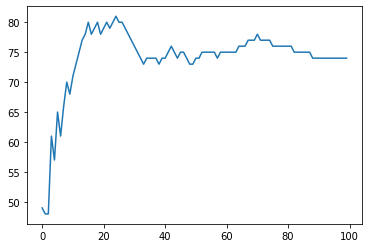

In [19]:
no_generations = 100
no_games = 100
learning_rate = 0.5
discount_factor = 0.7
winrates = run_generations(no_generations, no_games, learning_rate, discount_factor)
generations = range(0, no_generations)
print("Final win/draw rate : " + str(winrates[no_generations-1])+"%" )
plt.plot(generations,winrates)
plt.show()

This plot shows the agents performance for a lower discount factor. It can be seen that the agents winrates drop significantly. This means that for a lower discount rate, the agent only cares about the next immediate reward, resulting in decreased performance with bad results. With higher discount factor i.e. 0.95, it can be seen that the agent looks for future rewards and the higher factor value helps the agent converge towards better outcomes. 

Thus, for the succeeding experiments, I will be using a learning rate of 0.5 and a discount_factor of 0.95. We will also be observing outputs for a higher number of games played for more generations.

2023-12-10 23:24:54.863787: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2023-12-11 01:26:54.863766: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2023-12-11 02:50:54.863707: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2023-12-11 04:06:54.863746: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


Checkers Board Model updated by reinforcement learning & saved to: reinforced_model.json/h5
Final win/draw rate : 70%


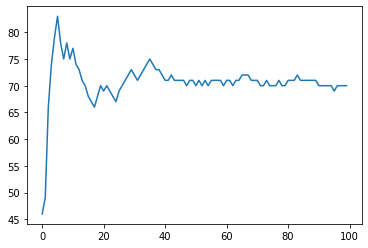

In [24]:
no_generations = 100
no_games = 500
learning_rate = 0.5
discount_factor = 0.95
winrates = run_generations(no_generations, no_games, learning_rate, discount_factor)
generations = range(0, no_generations)
print("Final win/draw rate : " + str(winrates[no_generations-1])+"%" )
plt.plot(generations,winrates)
plt.show()

Keeping the number of generations constant and increasing the number of games played, it seems that there isn't much imrprovement in the agent's performance. Since, the agents Q-values are updated at each generation, it might mean that the increasing the number of games played for same number of generations doesn't improve the agents performance significantly. However, it can be observed that the winrates at consecutive generations donot differ by much. This means that more number of games played provide a stable winrate for the given agent giving a stable performance.

Completed 0th iteration.


2023-12-11 23:27:24.514819: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


Completed 0th iteration.
Completed 0th iteration.
Checkers Board Model updated by reinforcement learning & saved to: reinforced_model.json/h5
Final win/draw rate : 76%


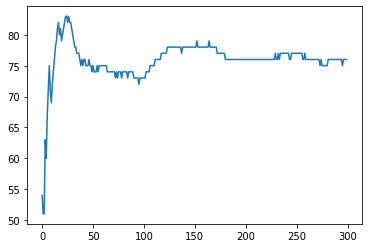

In [24]:
no_generations = 300
no_games = 300
learning_rate = 0.5
discount_factor = 0.95 
winrates = run_generations(no_generations, no_games, learning_rate, discount_factor)
generations = range(0, no_generations)
print("Final win/draw rate : " + str(winrates[no_generations-1])+"%" )
plt.plot(generations,winrates)
plt.show()

Finally, the agent is trained for 300 generations and 300 games played for each generation. It can be observed that the model's performance becomes steady, with less difference in winrate between consecutive generations. Similarly, the final agents winrates also improved significantly. 

## Conclusions

From the results, it can be seen that deep learning with generative adversarial networks can be used to develop a reinforced agent that is capable of playing Checkers with a reasonable winrate of approximately 80%. This was done by first creating a generative model fitted on the metrics from a heuristics function. Using this model, a discriminative model that evaluated a board position was created and reinforced through multiple generations with each generation having the agent play through multiple games. This approach seems more efficient than using Q-tables for the state-action pair, or using neural network approximations for a Q-function on Markov processes that we learned in the classes. Tweaking the hyperparameters of the adversarial networks, the chances of the agent improving in each game and generation can be increased. In the first few iterations, the agent learns very quickly, but after a while it stabilizes and gives steady performance. This might mean that the agent is capable of learning most of the board positions, but as it plays more games in each generation, it explores more board positions that are difficult to beat. 

This also shows that simply increasing the number of iterations, or tweaking the hyperparameters doesn't ensure improvement in performance. More experiments in the architecture of the adversarial networks or better methods to evaluate the board position might be needed to create a stronger agent. It was hard to figure out an optimal set of weights for the metrics function besides the ones used in the references. It was also difficult to determine set of hyperparameters and the network architecture for optimal performance as training times were significantly high, taking about 1 hour to train an agent through 100 generations with 100 games played in each generation. To obtain good results, the architecture and most of the hyperparameteres used for the adversarial network were similar to the ones in refered sources. 

Based on the works like [Henning,RL-Checkers], I was expecting a exponential and steady rise in the winrate and steady performance without any significant drops in the performance. But, as observed in the plots above, the model winrates would peak early and drop significantly. It was difficult to figure out what parameter was responsible for this. I experimented with lower learning rates to see if the fluctuations would get reduced but was getting similar results. It would have been interesting to explore more with various set of parameters and see their results but the training times for larger generatios were significantly high. 

Finally, with this project I learned about different approaches to develop deep learning models and use them for creating a reinforcement learning agent. It was a contrasting experience, compared to using Q-tables and neural network approximations with epsilon-greedy approach discussed in the classes. This has motivated me to further explore and study different types of learning mechanisms used by large corporations to develop intelligent agents for their products.   

### References

* [Q-learning] Christopher, J., Watkins, C.H., Dayan, P.: Q-learning. Mach. Learn. 8, 279–292 (1992)
* [Btsan-checkersbot] https://github.com/Btsan/CheckersBot/tree/master
* [Henning, RL-Checkers] Developing a Reinforcement Learning Agent
* [Goodfellow-Generative]Goodfellow, Ian, et al. "Generative adversarial networks." Communications of the ACM 63.11 (2020): 139-144.

In [7]:
import io
import nbformat
import glob
nbfile = glob.glob('CS545_ML_FinalReport.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file CS545_ML_FinalReport.ipynb is 2740
